In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [24]:
services = pd.read_csv('ServiceTimes.txt',sep="|")
#print(services)

## How does the data look like?

Following are few entries from the data file.

In [19]:
services.head()

,date,vcName,service,pid,boot_time_in_sec,last_started_at,last_triggered_at
0,1560146982,cloud02-w3.stls.local,vmdird,3449,3.034365,2019-06-10 06:09:45.530209,2019-06-10 06:09:42.495844
1,1560146985,cloud02-w3.stls.local,vmcad,3636,1.469778,2019-06-10 06:09:47.097548,2019-06-10 06:09:45.627770
2,1560146980,cloud02-w3.stls.local,vmafdd,3296,1.768963,2019-06-10 06:09:42.484698,2019-06-10 06:09:40.715735
3,1560146986,cloud02-w3.stls.local,analytics,3689,36.158827,2019-06-10 06:10:23.057000,2019-06-10 06:09:46.898173
4,1560146988,cloud02-w3.stls.local,applmgmt,3836,13.665166,2019-06-10 06:10:01.844000,2019-06-10 06:09:48.178834


In [20]:
from datetime import datetime as dt
services = services[services['service']!='system']

def convertToTimestamp(myt):
    if '.' in myt:
        return dt.strptime(myt,'%Y-%m-%d %H:%M:%S.%f').timestamp()
    else:
        return dt.strptime(myt,'%Y-%m-%d %H:%M:%S').timestamp()


services['start']=services['last_triggered_at'].apply(lambda x: convertToTimestamp(x))
services['finish']=services['last_started_at'].apply(lambda x: convertToTimestamp(x))

In [21]:
services.sort_values(by='start',ascending=True,inplace=True)

## Bar Chart of Services

Following chart shows the bar chart for time taken by a service to come up.
It is sorted in ascending order of the time at which the corresponding service became healthy.

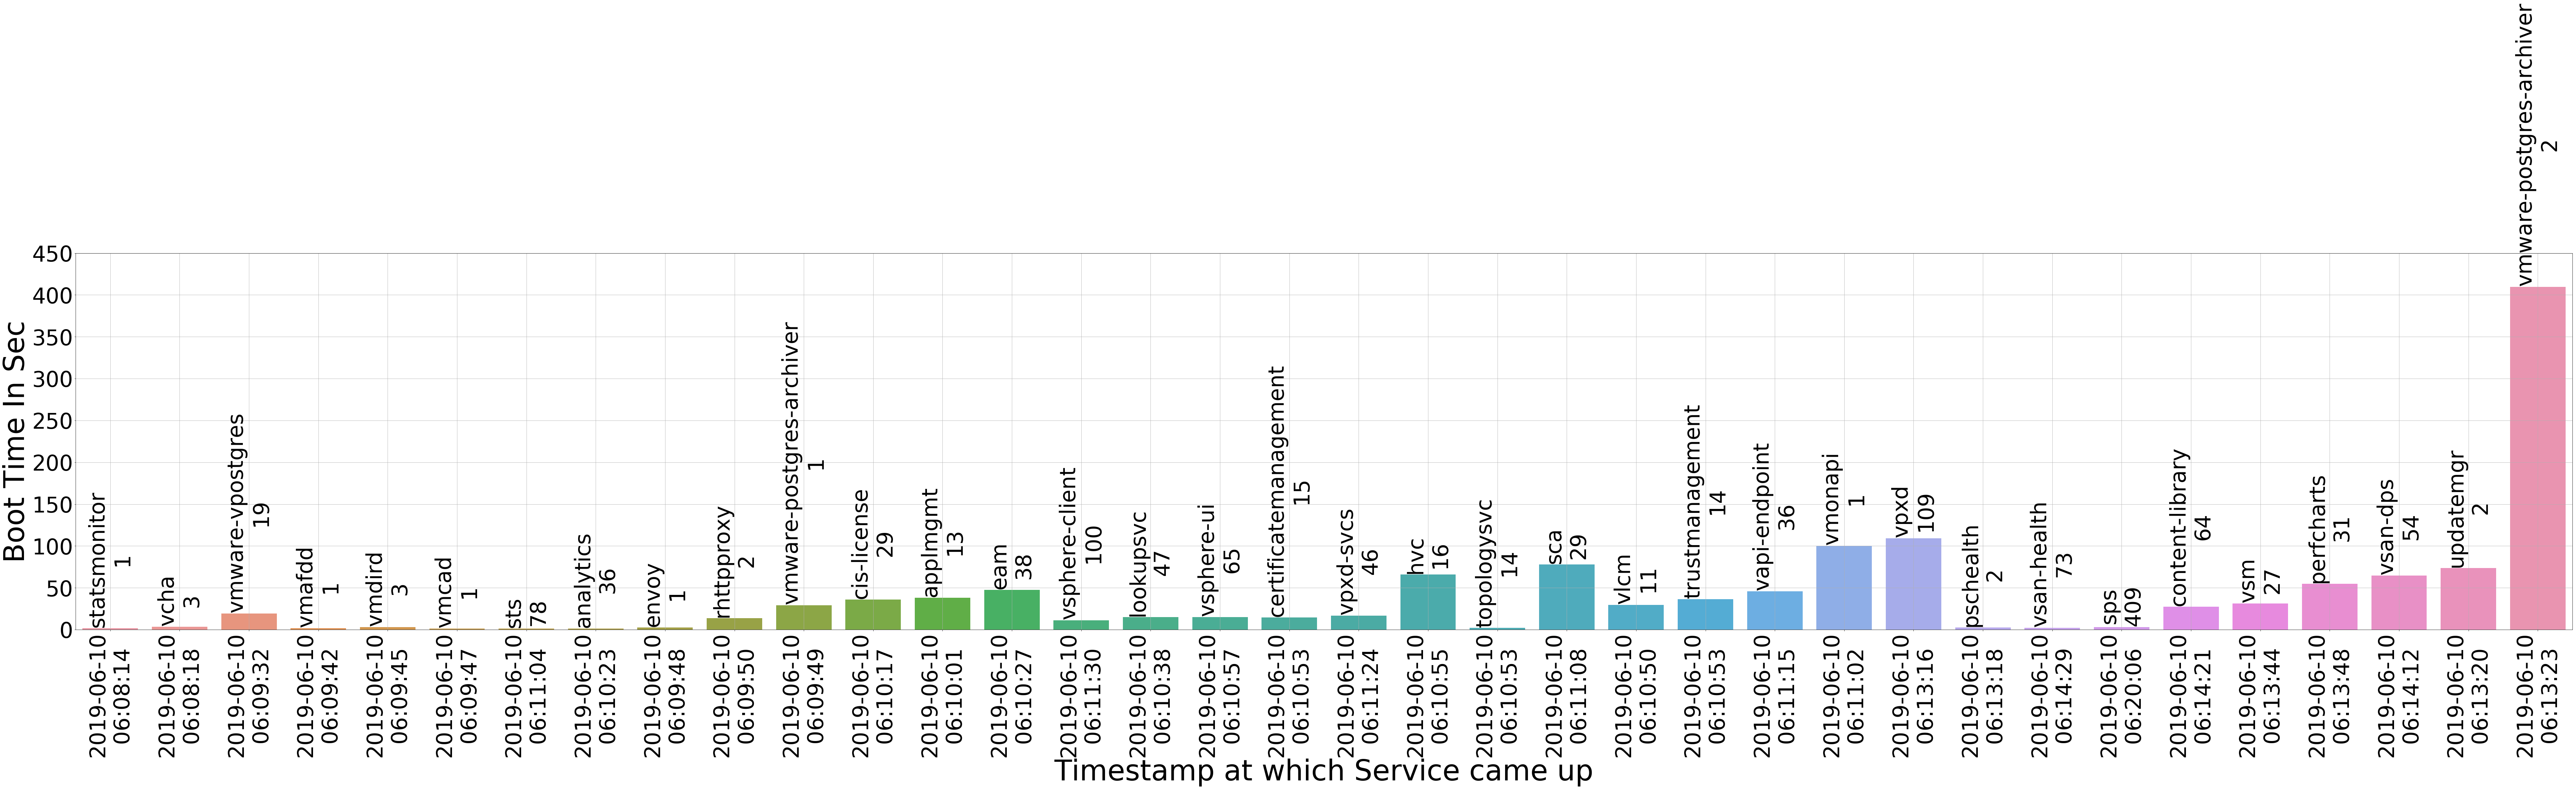

In [22]:
plt.figure(figsize=(100,30))
g = sns.barplot(data = services, x =  'finish', y = 'boot_time_in_sec')
plt.grid(True)
plt.xticks(rotation=90,fontsize=60)
plt.yticks(fontsize=60)
plt.xlabel("Timestamp at which Service came up",fontsize=80)
plt.ylabel("Boot Time In Sec",fontsize=80)
plt.ylim(0,450)
g.set_xticklabels(services["last_started_at"].astype(str).apply(lambda x: x.split(".")[0].replace(" ","\n")))

rects = g.patches

# Make some labels.
labels = services["service"]+"\n"+services['boot_time_in_sec'].apply(lambda x : str(x).split('.')[0])

for rect, label in zip(rects, labels):
    height = rect.get_height()
    g.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha='center', va='bottom',fontsize=60,rotation=90)
    
plt.tight_layout()
    
plt.savefig('service_plot1.png',dpi=300)
plt.show()




## Gantt Chart Representation

While the bar chart shows some information, such as which service took the highest time to come up, it lacks few critical insights.
Gantt chart provides a better visualization in this case.
It not only shows the comparison of the time taken by services, but can also display the information like which service were starting in parallel.

A Gantt Chart has x-axis as time. On y-axis an event is represented as a bar/line that spans from its respective start time and end time.

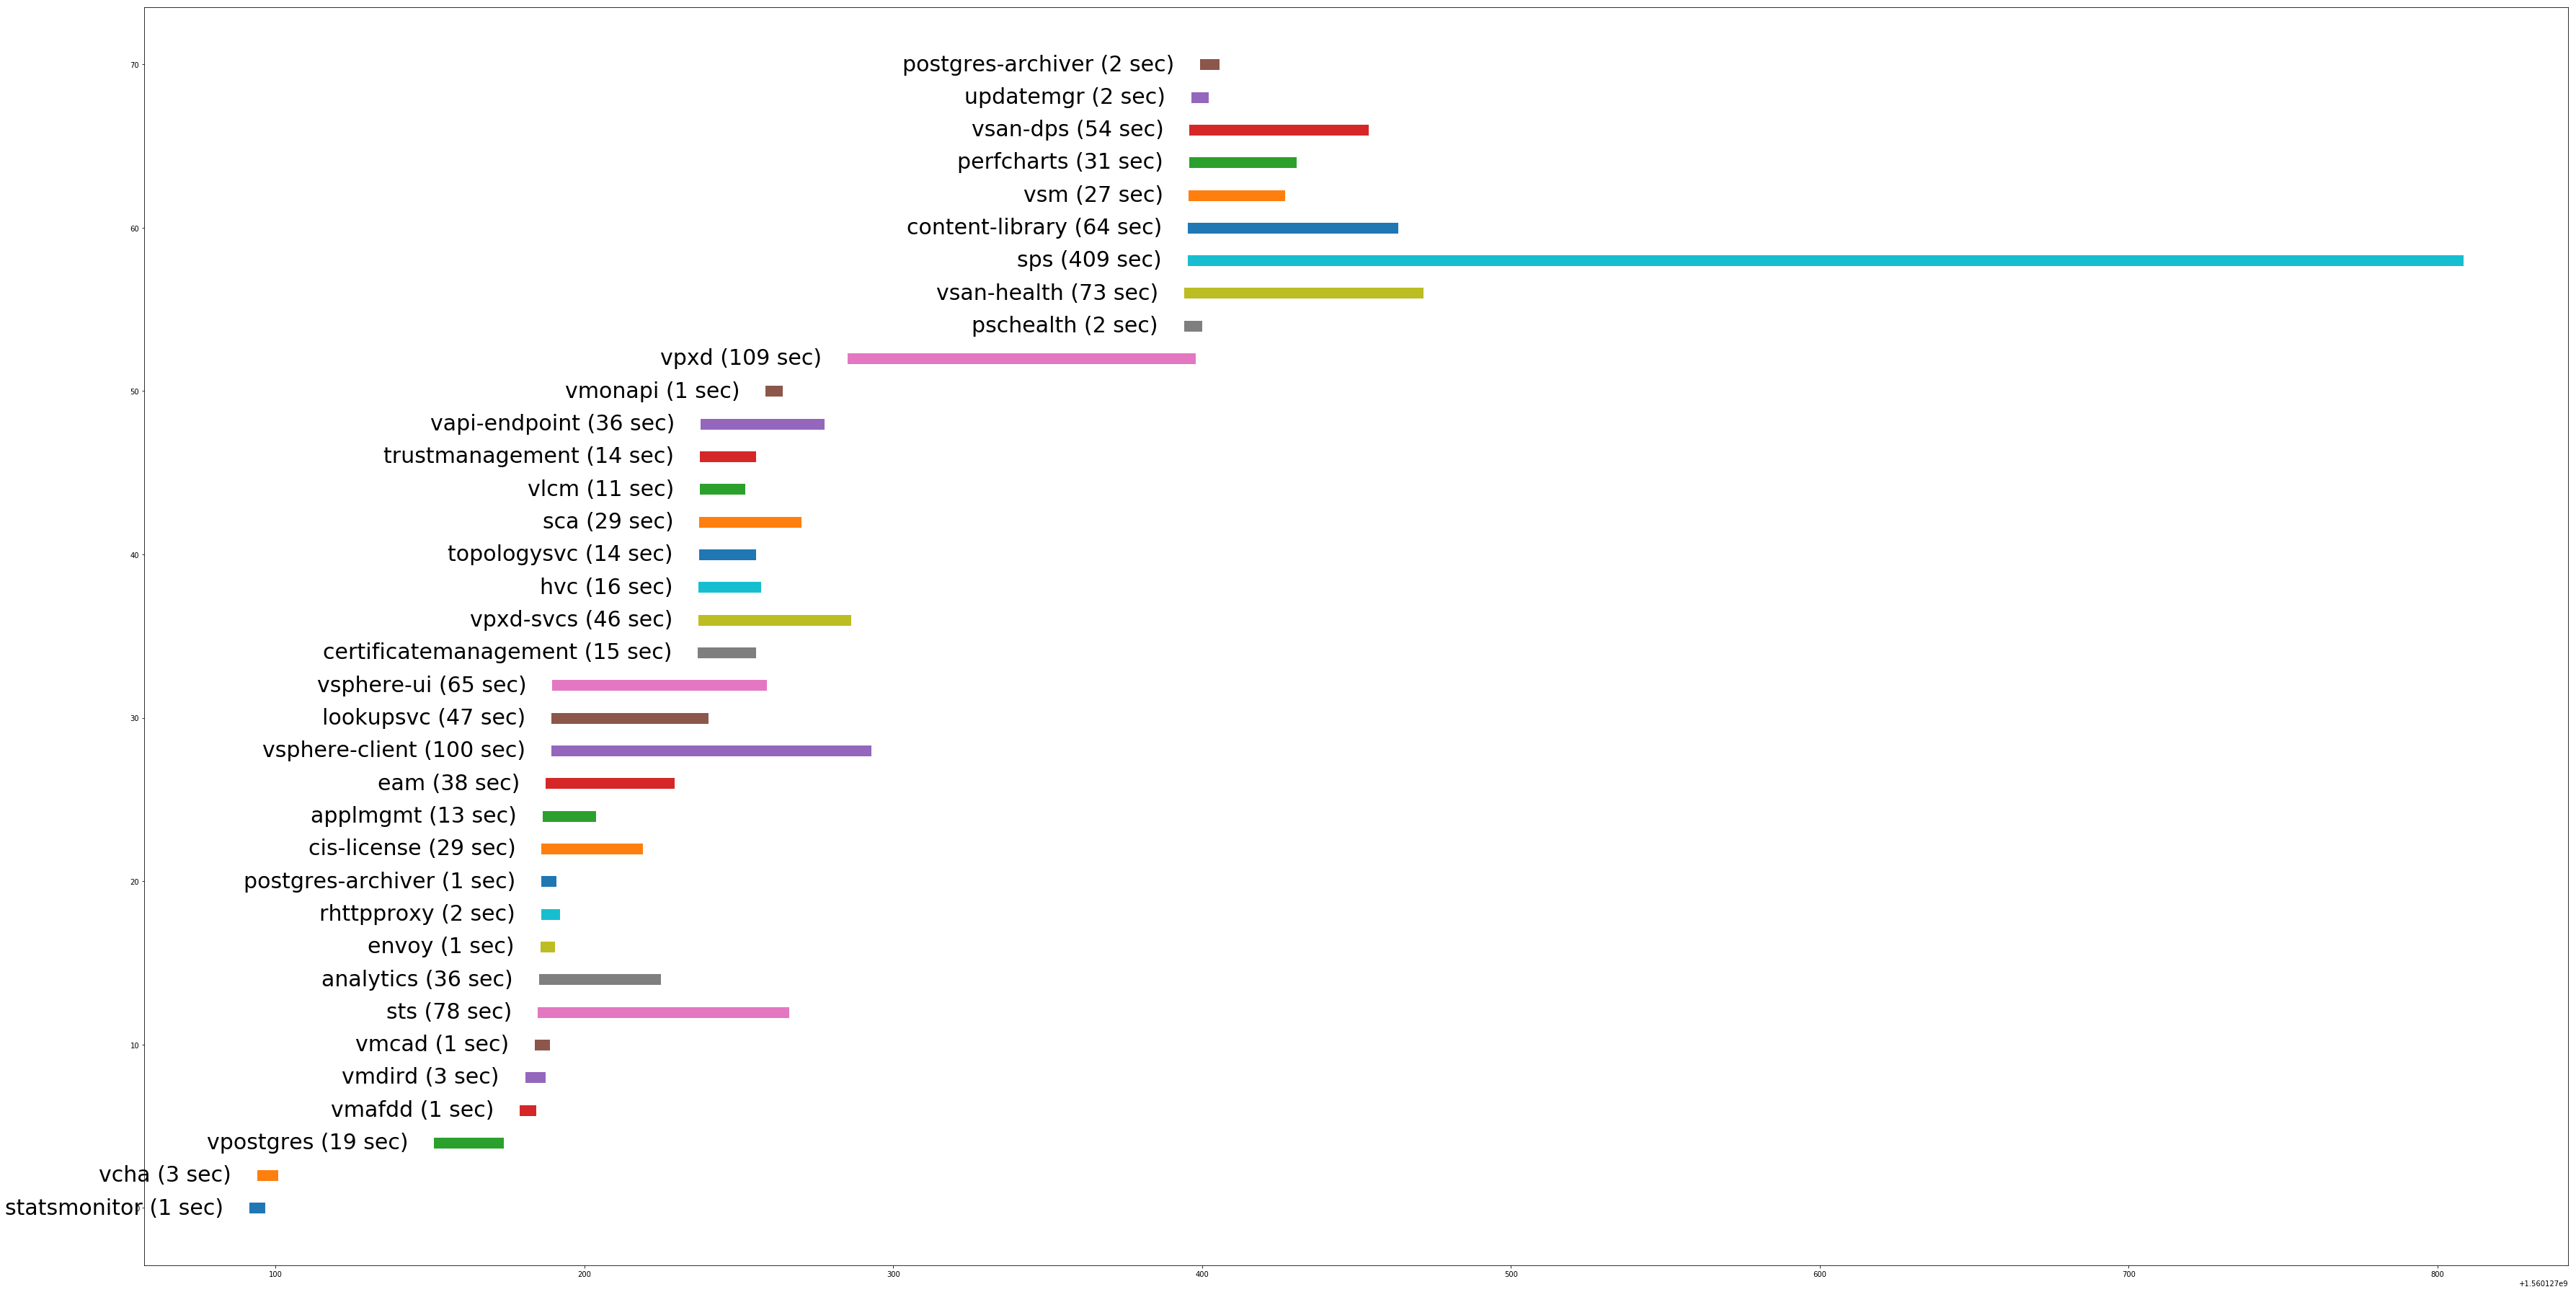

In [23]:
fig,ax = plt.subplots(figsize=(50,25))
#plt.ylim(-20,+20)

#plt.figure(figsize=(40,10))
cury = [1,2,3,4,5]
ci = 0
val = ["top","bottom"]
vi = 1
yi = 1
for i in range(services.shape[0]):
#for i in range(5):
    a = services.iloc[i]
    #if(a['finish']-a['start']>150):
    #    continue
    x = [a['start'],a['finish']]
    #print(x)
    #y = [cury[ci],cury[ci]]
    y = [2*i,2*i]
    plt.plot(x,y,ls='-',lw=15)#,ms=20,marker='o',markerfacecolor='black')
    #plt.plot([x[0],x[0]],[2*i-0.5,2*i+0.5],ls='--',lw=5)#,ms=20,marker='o',markerfacecolor='black')
    #plt.plot([x[1],x[1]],[2*i-0.5,2*i+0.5],ls='--',lw=5)
    yfactor = yi*3*(cury[(ci+4)%5])
    bx = [(x[0]+x[1])/2,(x[0]+x[1])/2]
    by = [cury[ci],yfactor]
    #plt.plot(bx,by,lw = 5)
    #markerline, stemlines, baseline = plt.stem(bx,by)
    #plt.setp(stemlines, 'linewidth', 5)
    myl = a["service"].replace('vmware-','') + " (" +str(a["boot_time_in_sec"]).split(".")[0] + " sec)"
    myl2 = a["last_triggered_at"].split(" ")[1][:11]
    myl3 = a["last_started_at"].split(" ")[1][:11]
    ax.text(x[0]-10,2*i,myl,ha='right',va='center',fontsize=30,rotation = 0)
    #ax.text(x[1]+5,2*i,myl2 + " to "+myl3,ha='left',va='center',fontsize=30,rotation = 0)
    vi=1-vi
    yi = -yi
    ci = (ci+1)%5

    
plt.tight_layout()
    
plt.savefig('service_plot2.png',dpi=300)

plt.show()

## Vpxd Component Start Times

While service start times are useful to see which services are taking longer to start, it may not tell why.
Our next goal is to analyze each service and its subcomponent to know, why a particular service takes that long.

For example, we have this info for vpxd.


## How does the vpxd data look like?

In [38]:
df_vpxd = pd.read_csv('VpxdTimes.txt')
df_vpxd.head()

,time,stcomp_vpxd_timestamp,source,hostname,stcomp_vpxd_subcomp_name,Max of stcomp_vpxd_comp_api_time (ST Charts)
0,2019-06-17T10:40:30.000Z,2019-06-17t10:40:33,10.146.13.19,cloud02-w3.stls.local,dopoststartup [vpxdclientpreload::preloadclien...,3414
1,2019-06-17T10:40:30.000Z,2019-06-17t10:40:34,10.146.13.19,cloud02-w3.stls.local,dopoststartup [vpxdinvtstoragepod::populateact...,961
2,2019-06-17T10:40:25.000Z,2019-06-17t10:40:29,10.146.13.19,cloud02-w3.stls.local,serverapp::start [totaltime],34600
3,2019-06-17T10:40:25.000Z,2019-06-17t10:40:26,10.146.13.19,cloud02-w3.stls.local,start [vpxdinvthost::start()],2942
4,2019-06-17T10:40:25.000Z,2019-06-17t10:40:29,10.146.13.19,cloud02-w3.stls.local,start [vapiendpoint::start()],2231


## Preprocessing

In [39]:
from datetime import datetime as dt
df_vpxd['date'] = df_vpxd["stcomp_vpxd_timestamp"].apply(lambda x : dt.strptime(x,"%Y-%m-%dt%H:%M:%S").timestamp())


df_vpxd['time'] = df_vpxd["stcomp_vpxd_timestamp"].astype(str).apply(lambda x: x.replace('t','\n'))
df_vpxd.sort_values(by='date',ascending=True,inplace=True)
df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'] = df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)']/1000
df_vpxd['duration']=df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)']
df_vpxd['start'] = df_vpxd["date"]-df_vpxd['duration']
df_vpxd['finish'] = df_vpxd['date']
df_vpxd = df_vpxd[df_vpxd['stcomp_vpxd_subcomp_name'].apply(lambda x : 'dopoststart' not in x)]

## Bar Chart for Vpxd Component Times

C:\Users\ybendre\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


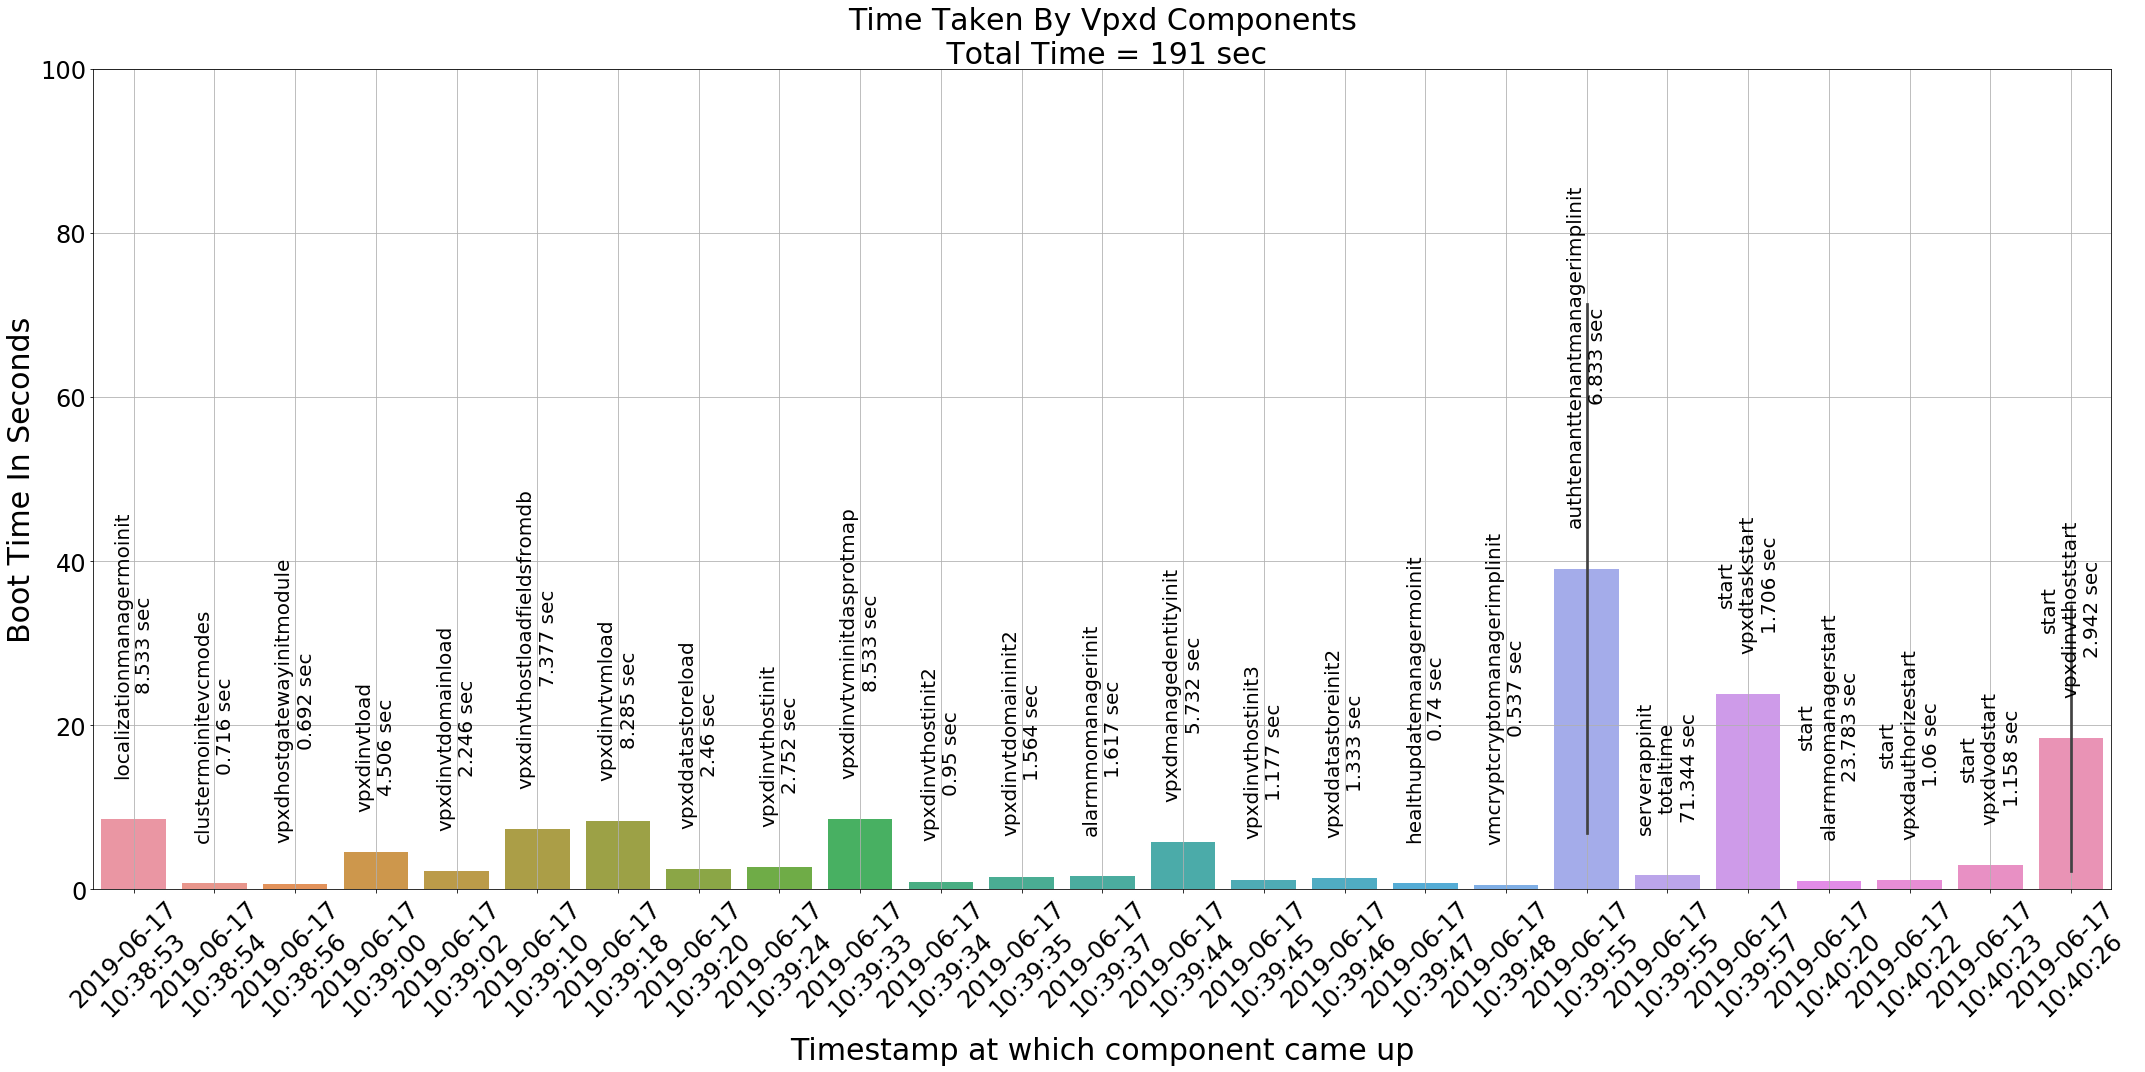

In [40]:
plt.figure(figsize=(30,15))
g = sns.barplot(data = df_vpxd, x =  'date', y = 'Max of stcomp_vpxd_comp_api_time (ST Charts)')

vpxd_pid_date = '2019-06-17 10:38:38.667223'
vpxd_start_date = '2019-06-17 10:40:37.675000'

nx = [int(dt.strptime(vpxd_pid_date,'%Y-%m-%d %H:%M:%S.%f').timestamp()), int(dt.strptime(vpxd_start_date,'%Y-%m-%d %H:%M:%S.%f').timestamp())]
ny = df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'].max()+20

#g.text(nx[0],y,"bla")

#sns.lineplot(data=df_vpxd.head(2),x='date',y='Max of stcomp_vpxd_comp_api_time (ST Charts)')

#g.text('1559783904','72.7128',"Bla",color='black',ha='center')
totalTime = (int)(df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'].astype(int).sum())
plt.title("Time Taken By Vpxd Components\n Total Time = "+str(totalTime)+" sec",fontsize=30)

plt.grid(True)
plt.xticks(rotation=45,fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Timestamp at which component came up",fontsize=30)
plt.ylabel("Boot Time In Seconds",fontsize=30)
plt.ylim(0,100)


#print(df_vpxd['date'].astype(int))
#print(x)
#print(y)



g.set_xticklabels(df_vpxd["time"])

rects = g.patches

# Make some labels.
#labels = df_vpxd["stcomp_vpxd_subcomp_name"].apply(lambda x: x.replace("::","\n").replace("(","").replace(")","").replace("[","").replace("]","").replace(" ","\n"))+"\n"+df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'].astype(str)+" sec"
labels = df_vpxd["stcomp_vpxd_subcomp_name"].apply(lambda x: x.replace("::","").replace("(","").replace(")","").replace("[","").replace("]","").replace(" ","\n"))+"\n"+df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'].astype(str)+" sec"

for rect, label in zip(rects, labels):
    height = rect.get_height()
    g.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom',fontsize=20,rotation=90)
    
plt.tight_layout()
    
plt.savefig('myplot2.png',dpi=300)




## Gantt Chart for Vpxd Components

Similar to Services, the bar chart may not convey all the information.
We may think that, the time taken by vpxd to come up is total of all the times taken by components.
Gantt chart shows entirely different perspective.

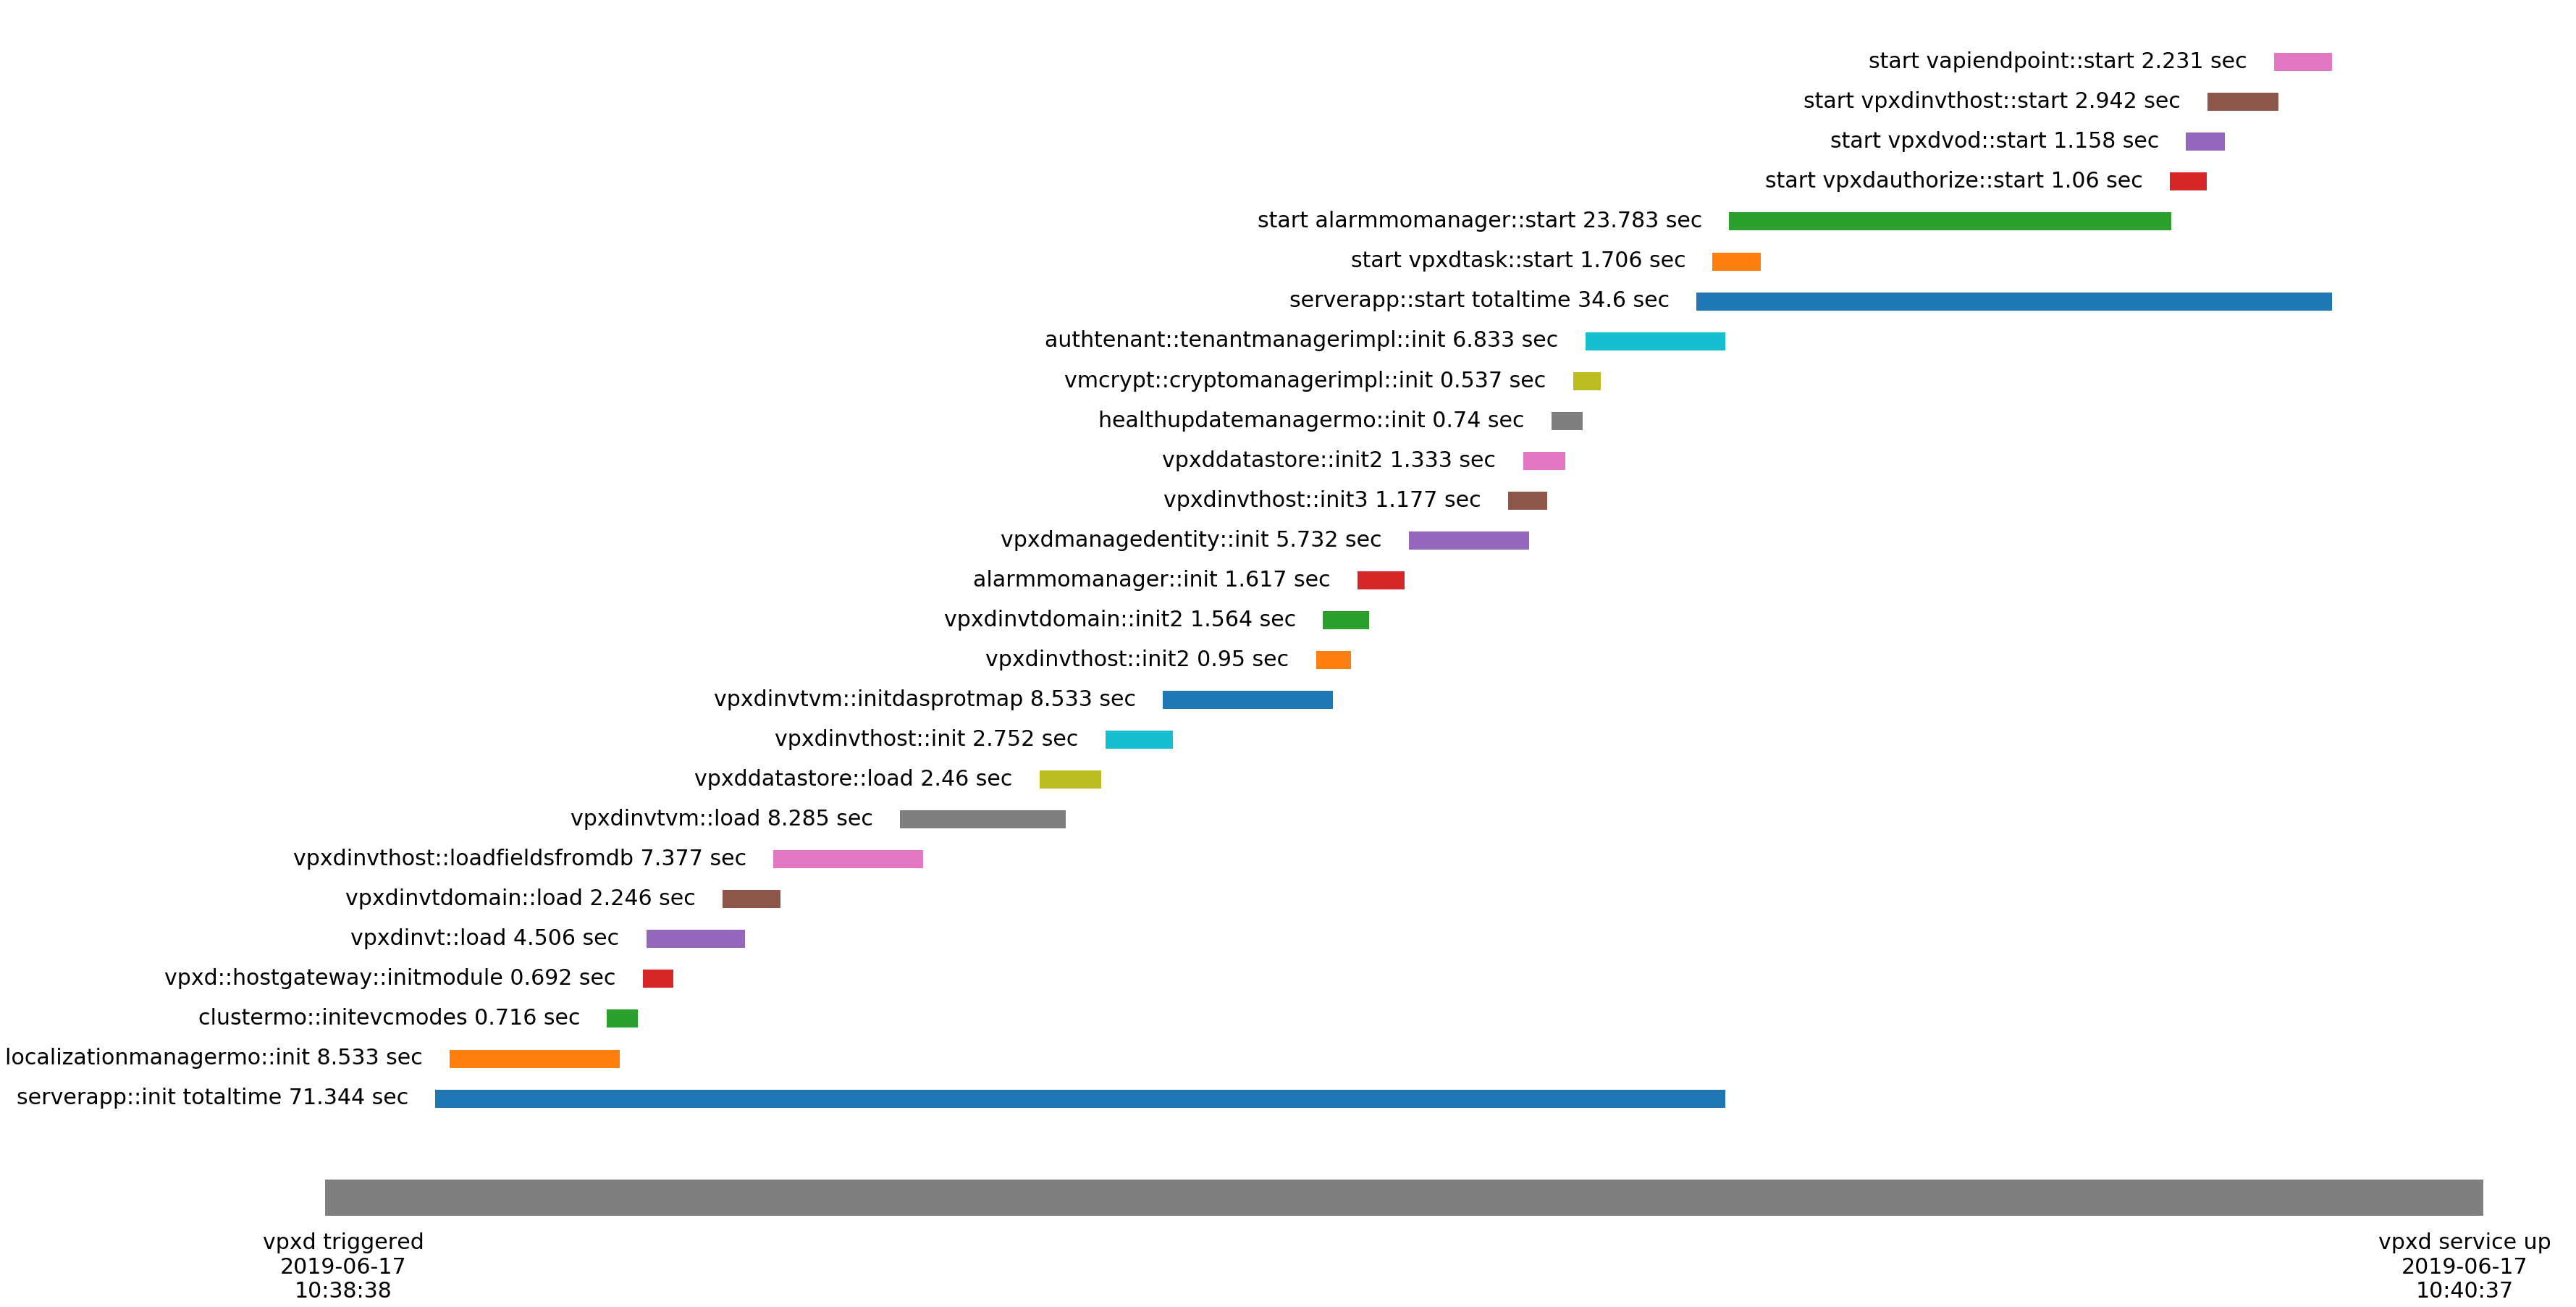

In [41]:
df_vpxd = df_vpxd.sort_values(by='start',ascending=True)
fig,ax = plt.subplots(figsize=(50,25))
maxy = 0
#ax.get_yaxis().set_visible(False)
ax.axis('off')
for i in range(df_vpxd.shape[0]):

    a = df_vpxd.iloc[i]
    #print(a)
    x = [a['start'],a['finish']]
    #print(x)
    mylabel = a["stcomp_vpxd_subcomp_name"].replace("(","").replace(")","").replace("[","").replace("]","")+" "+str(a['duration'])+" sec"
    #print(mylabel)
    y = [2*i,2*i]
    maxy = 2*i
    plt.plot(x,y,ls='-',lw=25)#,ms=20,marker='o',markerfacecolor='black')
    ax.text(x[0]-2,y[0],mylabel,ha='right',va='center',fontsize=30,rotation = 0)

vpxd_pid_date = '2019-06-17 10:38:38.667223'
vpxd_start_date = '2019-06-17 10:40:37.675000'

nx = [int(dt.strptime(vpxd_pid_date,'%Y-%m-%d %H:%M:%S.%f').timestamp()), int(dt.strptime(vpxd_start_date,'%Y-%m-%d %H:%M:%S.%f').timestamp())]
#y = df_vpxd['Max of stcomp_vpxd_comp_api_time (ST Charts)'].max()+20
nx_1 = [int(dt.strptime(vpxd_pid_date,'%Y-%m-%d %H:%M:%S.%f').timestamp())-2, int(dt.strptime(vpxd_start_date,'%Y-%m-%d %H:%M:%S.%f').timestamp())+2]

y=-5
ny=[y,y]
nx2=[nx_1[1],nx_1[1]+2]
ny2 = [ny[0],maxy+2]
#plt.plot(nx2,ny2,lw=10,ls='--',color='black')

nx2=nx_1
ny2 = [maxy+2,maxy+2]
#plt.plot(nx2,ny2,lw=10,ls='--',color='black')

nx2=[nx_1[0],nx_1[0]]
ny2 = [ny[0],maxy+2]
#plt.plot(nx2,ny2,lw=10,ls='--',color='black')
plt.plot(nx,ny,'o',markersize=15,lw=50,ls='-')

nx2=nx_1
ny2 = [ny[0]-2,ny[0]-2]
#plt.plot(nx2,ny2,lw=10,ls='--',color='black')



ax.text(nx[0], y-5, 'vpxd triggered\n'+vpxd_pid_date.split('.')[0].replace(' ','\n'),fontsize=30,ha='center')
ax.text(nx[1], y-5, 'vpxd service up\n'+vpxd_start_date.split('.')[0].replace(' ','\n'),fontsize=30,ha='center')

plt.tight_layout()
    
plt.savefig('vpxd.png',dpi=300)

plt.show()